# Getting Started with Mapper

In this notebook we explore a few of the core features included in giotto-learn's implementation of the [Mapper algorithm](https://research.math.osu.edu/tgda/mapperPBG.pdf). 

## Useful references

* [An introduction to Topological Data Analysis: fundamental and practical aspects for data scientists](https://arxiv.org/abs/1710.04019)
* [An Introduction to Topological Data Analysis for Physicists: From LGM to FRBs](https://arxiv.org/abs/1904.11044)

#### License: AGPLv3

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# data wrangling
import numpy as np
import pandas as pd

# data viz
import plotly.graph_objects as go

# tda magic
from giotto.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)
from giotto.mapper.utils.visualization import set_node_sizeref

# from giotto.mapper.utils.visualization import set_node_sizeref

# ml tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Generate and visualise data
As a simple example, let's generate a two-dimensional point cloud of two concentric circles. The goal will be to examine how Mapper can be used to generate a topological graph that captures the salient features of the data.

In [3]:
data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)

fig = go.Figure(
    data=go.Scatter(x=data[:, 0], y=data[:, 1], mode="markers"),
    layout={"autosize": False},
)
fig.show()

## Configure the Mapper pipeline
Given a dataset ${\cal D}$ of points $x \in \mathbb{R}^n$, the basic steps behind Mapper are as follows:

1. Map ${\cal D}$ to a lower-dimensional space using a _**filter function**_ $ f: \mathbb{R}^n \to \mathbb{R}^m $. Common choices for the filter function include projection onto one or more axes via PCA or density-based methods. In giotto-learn, you can import a variety of filter functions as follows:

```python
from giotto.mapper.filter import FilterFunctionName
```

2. Construct a cover of the filter values ${\cal U} = (U_i)_{i\in I}$, typically in the form of a set of overlapping intervals which have constant length. As with the filter, a choice of cover can be imported as follows:

```python
from giotto.mapper.cover import CoverName
```

3. For each interval $U_i \in {\cal U}$ cluster the points in the preimage $f^{-1}(U_i)$ into sets $C_{i,1}, \ldots , C_{i,k_i}$. The choice of clustering algorithm can be any of scikit-learn's [clustering methods](https://scikit-learn.org/stable/modules/clustering.html) or an implementation of agglomerative clustering in giotto-learn:

```python
# scikit-learn method
from sklearn.cluster import ClusteringAlgorithm
# giotto-learn method
from giotto.mapper.cluster import FirstSimpleGap
```

4. Construct the topological graph whose vertices are the cluster sets $(C_{i,j})_{i\in I, j \in \{1,\ldots,k_i\}}$ and an edge exists between two nodes if they share points in common: $C_{i,j} \cap C_{k,l} \neq \emptyset$. This step is handled automatically by giotto-learn.

These four steps are implemented in the `MapperPipeline()`  object that mimics the `Pipeline()` class from scikit-learn. We provide a convenience function `make_mapper_pipeline()` that allows you to pass the choice of filter function, cover, and clustering algorithm as arguments. For example, to project our data onto the $x$- and $y$-axes, we could setup the pipeline as follows:

In [4]:
# define filter function - can be any scikit-learn Transformer
filter_func = Projection(columns=[0, 1])
# define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# choose clustering algorithm - default is DBSCAN
clusterer = DBSCAN()

# configure parallelism of clustering step
parallel_clustering_n_jobs = 1

# initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    parallel_clustering_n_jobs=parallel_clustering_n_jobs,
)

## Visualise the Mapper graph

With the Mapper pipeline at hand, it is now a simple matter to visualise it. To warm up, let's examine the graph in two-dimensions using the default arguments of giotto-learn's plotting function:

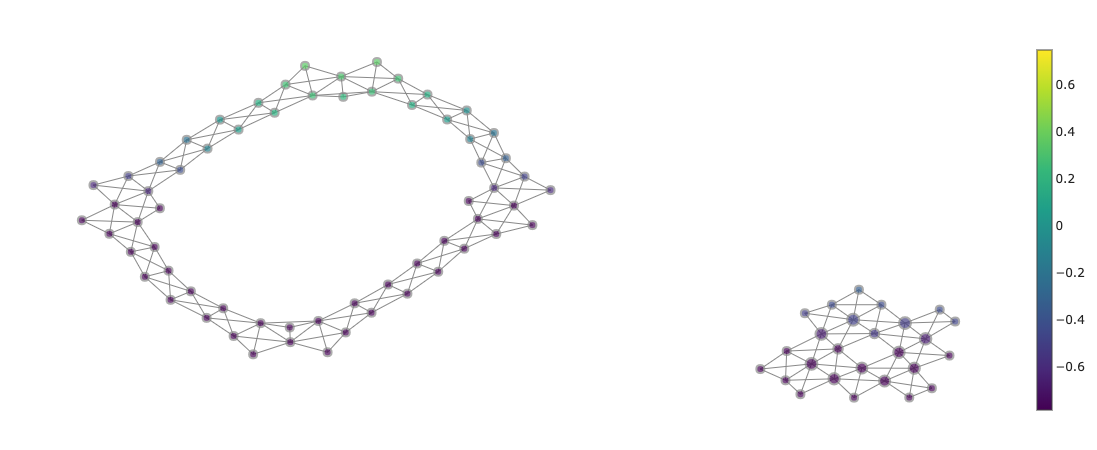

In [5]:
fig = plot_static_mapper_graph(pipe, data)
# display figure
fig.show(config={"scrollZoom": True})

From the figure we can see that we have captured the salient topological features of our underlying data, namely two holes!

### Configure the coloring of the Mapper graph
By default, the nodes of the Mapper graph are colored by the mean value of the points that belong to a given node. However, in this example it is more instructive to colour by the $x$- and $y$-axes. This can be achieved by toggling the `color_by_columns_dropdown`, which calculates the coloring for each column in the input data array. At the same time, let's configure the choice of colorscale:

In [6]:
plotly_kwargs = {
    'node_trace_marker_colorscale':'Blues'
}
fig = plot_static_mapper_graph(pipe, data, color_by_columns_dropdown=True, plotly_kwargs=plotly_kwargs)
# display figure
fig.show(config={"scrollZoom": True})

In the dropdown menu, the entry `color_variable` refers to a user-defined quantity to color by - by default it is the average value of the points in each node. In general, one can configure this quantity to be an array, a scikit-learn transformer, or a list of indices to select from the data. For example, coloring by a PCA component can be implemented as follows:

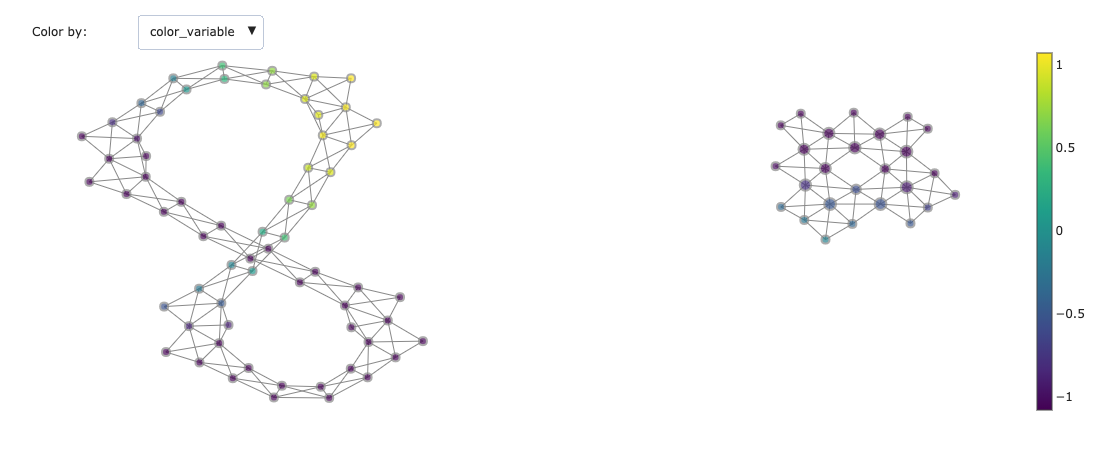

In [7]:
# initialise estimator to color graph by
pca = PCA(n_components=1).fit(data)

fig = plot_static_mapper_graph(pipe, data, color_by_columns_dropdown=True, color_variable=pca)
# display figure
fig.show(config={"scrollZoom": True})

### Change the layout algorithm
By default, `plot_static_mapper_graph()` uses the Kamada–Kawai algorithm for the layout; however any of the layout algorithms defined in python-igraph are supported (see [here](https://igraph.org/python/doc/igraph.Graph-class.html) for a list of possible layouts). For example, we can switch to the Fruchterman–Reingold layout as follows:

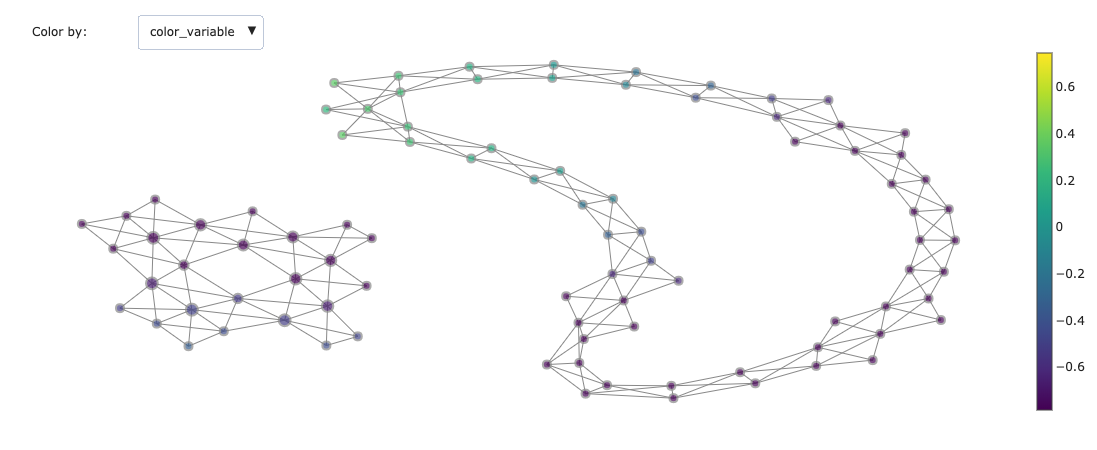

In [8]:
fig = plot_static_mapper_graph(pipe, data, layout='fruchterman_reingold', color_by_columns_dropdown=True)
# display figure
fig.show(config={"scrollZoom": True})

### Change the layout dimension
It is also possible to visualise the Mapper graph in 3-dimensions by configuring the `layout_dim` argument:

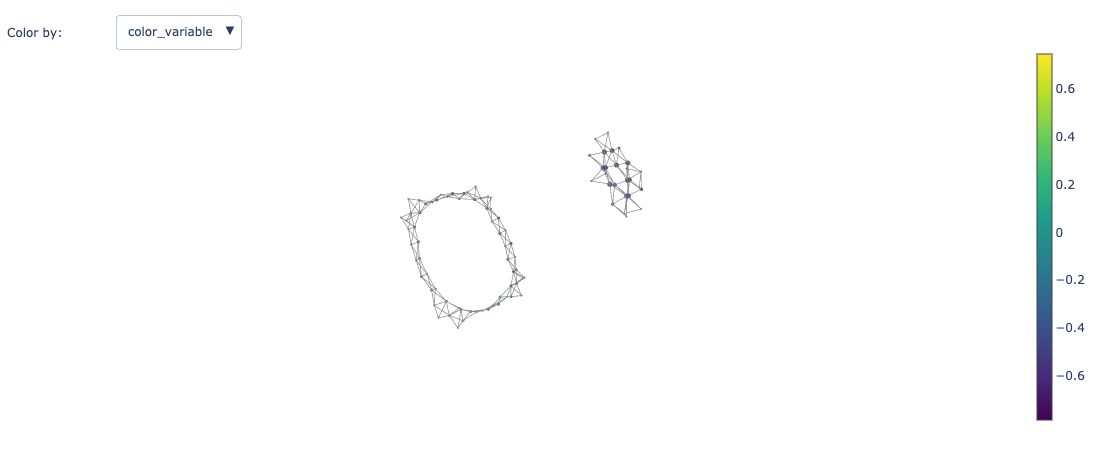

In [9]:
fig = plot_static_mapper_graph(pipe, data, layout_dim=3, color_by_columns_dropdown=True)
# display figure
fig.show(config={"scrollZoom": True})

## Run the Mapper pipeline
Behind the scenes of `plot_static_mapper_graph()` is a `MapperPipeline()` object `pipe` that can be used like a typical scikit-learn estimator. For example, to extract the underlying graph data structure we can do the following:

In [10]:
graph = pipe.fit_transform(data)

The resulting graph is an [python-igraph](https://igraph.org/python/) object that contains metadata that is stored in the form of dictionaries. We can access this data as follows:

In [11]:
graph['node_metadata'].keys()

dict_keys(['node_id', 'interval_id', 'cluster_id', 'node_elements'])

Here `node_id` is an identifier used to construct the graph, while `interval_id` and `cluster_id` refer to the interval and cluster sets described above. The `node_elements` refers to the indices of our original data that belong to each node. For example, to find which points belong to the first node of the graph we can access the desired data as follows:

In [12]:
node_id, node_elements = graph['node_metadata']['node_id'], graph['node_metadata']['node_elements']

In [13]:
print('Node Id: {}, \nNode elements: {}, \nData points: {}'.format(node_id[0], node_elements[0], data[node_elements[0]]))

Node Id: 0, 
Node elements: [1675 1944 2425 4464], 
Data points: [[-0.85719291 -0.74172245]
 [-0.88187702 -0.69106254]
 [-0.8881879  -0.63188784]
 [-0.84665374 -0.73453227]]


The `node_elements` are handy for situations when we want to customise e.g. the size of the node scale. In this example, we use the utility function `set_node_sizeref()` and pass the function as a plotly argument:

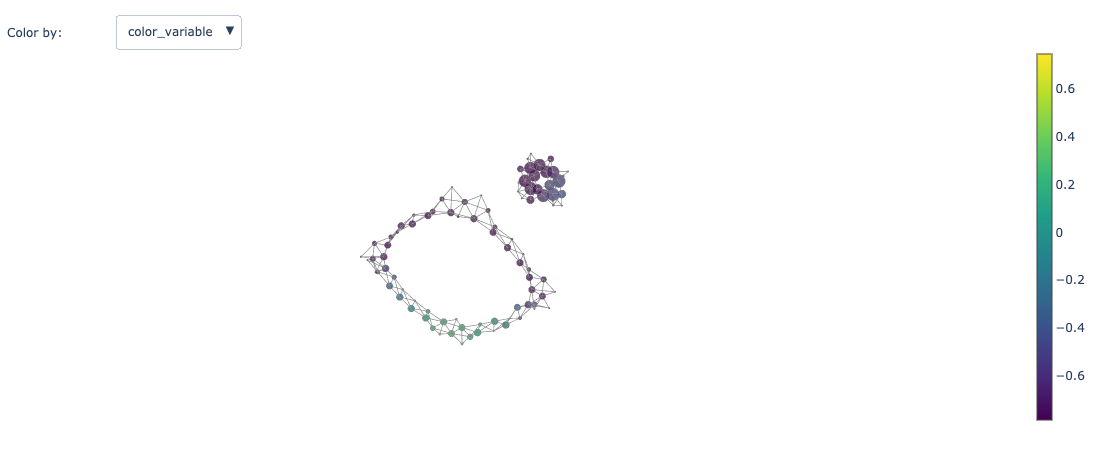

In [14]:
# configure scale for node sizes
plotly_kwargs = {
    "node_trace_marker_sizeref": set_node_sizeref(node_elements, node_scale=30)
}
fig = plot_static_mapper_graph(pipe, data, layout_dim=3, color_by_columns_dropdown=True, plotly_kwargs=plotly_kwargs)
# display figure
fig.show(config={"scrollZoom": True})

The resulting graph is much easier to decipher with the enlarged node scaling!

## Creating custom filter functions
In some cases, the list of filter functions provided in `filter.py` or scikit-learn may not be sufficient for the task at hand. In such cases, one can pass any callable to the pipeline that acts _row-wise_ on the input data. For example, we can project by taking the sum of the $(x,y)$ coordinates as follows:

In [15]:
filter_func = np.sum

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=True,
    parallel_clustering_n_jobs=parallel_clustering_n_jobs,
)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


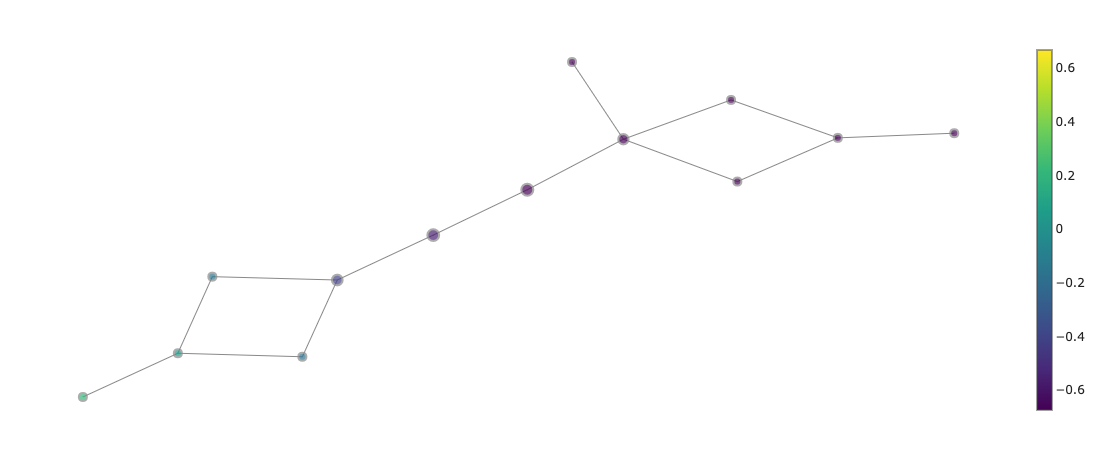

In [16]:
fig = plot_static_mapper_graph(pipe, data, plotly_kwargs=None)
# display figure
fig.show(config={"scrollZoom": True})

In general, any callable (i.e. function) that operates **_row-wise_** can be passed. For example we can filter by the ratio of $x$- and $y$-coordinates as follows:

In [17]:
def calculate_xy_ratio(row):
    return row[0] / row[1]

In [18]:
pipe = make_mapper_pipeline(
    filter_func=calculate_xy_ratio,
    cover=cover,
    clusterer=clusterer,
    verbose=True,
    parallel_clustering_n_jobs=parallel_clustering_n_jobs,
)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.3s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


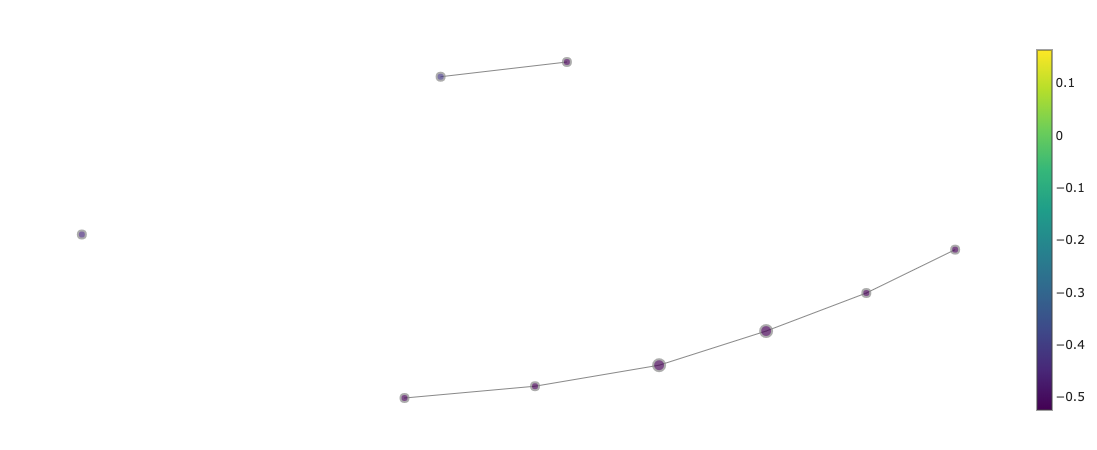

In [19]:
fig = plot_static_mapper_graph(pipe, data, plotly_kwargs=None)
# display figure
fig.show(config={"scrollZoom": True})

## Visualise the 2D Mapper graph interactively
In general, buidling useful Mapper graphs requires some iteration through the various parameters in the cover and clustering algorithm. To simplify that process, giotto-learn provides an interactive figure that can be configured in real-time. If invalid parameters are selected, the _Show logs_ checkbox can be used to see what went wrong.

In [20]:
pipe = make_mapper_pipeline()

# generate interactive plot
plot_interactive_mapper_graph(pipe, data, color_by_columns_dropdown=True)

Output()